In [1]:
import numpy as np
from tqdm.notebook import tqdm

In [2]:
class GridWorld:
    
    """Gridworld as MDP"""
    def __init__(self, m, n):
        self.m = m
        self.n = n
        self.grid = np.zeros(shape = (m,n))
        self.end = False
        self.goal_tile = 7
        self.wall_tile = 9
        self.ice_tile = 1
        self.figure = 5

        # possible actions
        self.actions = ["up", "down", "right", "left"]

        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
    
        self.grid[1][1] = self.ice_tile
        self.grid[1][2] = self.ice_tile
        self.grid[1][3] = self.wall_tile
        self.grid[3][3] = self.wall_tile
        
    def reset(self):
        self.end = False
        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
        
        self.grid[1][1] = self.ice_tile
        self.grid[1][2] = self.ice_tile

    def __getitem__(self, grid):
        print(self.grid)
        return self.grid

    # a function that returns the four tiles that are visible to the agent
    def visible_tiles(self):
        x,y = self.current_pos()
        visible_tiles = []
        for i in self.actions:
            next, next_two, con, con2 = self.action_parameter(i)
            if con == True:
                visible_tiles.append(self.grid[next])
        return visible_tiles
    
    #state (tile on which the agent is positioned)
    def current_pos(self):
        found = False
        for x in range(self.m):
            for y in range(self.n):
                if self.grid[x,y] == self.figure:
                    found = True
                    break
            if found == True:
                break
        return x,y

    # return random action and activates it
    def get_random_action(self):
        action = np.random.choice(self.actions)
        self.move(action)
        return action
    
    def action_parameter(self, action):
        x, y = self.current_pos()
        con = False
        con2 = False
        if action == "up":
            next = x-1,y
            next_two = x-2,y
            if x-1 >= 0:
                con = True
            if x-2 >= 0:
                con2 = True

        elif action == "down":
            next = x+1,y
            next_two = x+2,y
            if x+1 <= self.m-1:
                con = True
            if x+2 <= self.m-1:
                con2 = True

        elif action == "right":
            next = x,y+1
            next_two = x,y+2
            if y+1 <= self.n-1:
                con = True
            if y+2 <= self.n-1:
                con2 = True
        elif action == "left":
            next = x,y-1
            next_two = x,y-2
            if y-1 >= 0:
                con = True
            if y-2 >= 0:
                con2 = True
        return next, next_two, con, con2
            
    def move(self, action):
        next, next_two, con, con2 = self.action_parameter(action)
        x, y = self.current_pos()
        if con == True:
            self.grid[x,y] = 0
            # if the agent reaches the goal, the game ends
            if self.grid[next] == self.goal_tile:
                # self.grid[next] = self.figure
                self.end = True
            # if the agent reaches an icy tile, it moves two steps left
            elif self.grid[next] == self.ice_tile and con2 == True:
                if self.grid[next_two] == self.goal_tile:
                    # self.grid[next_two] == self.figure
                    self.end = True
                elif self.grid[next_two] == self.wall_tile:
                    self.grid[next] = self.figure
                else:
                    self.grid[next_two] = self.figure          
            # if the agent reaches a wall, it cannot move
            elif self.grid[next] == self.wall_tile:
                self.grid[x,y] = self.figure
            elif self.grid[next] == 0:
                self.grid[next] = self.figure

    def get_reward(self):
        if self.current_pos == self.goal_tile:
            return 100
        else:
            return -1

    # initialize a policy
    def initialize_policy(self):
        policy = np.zeros(shape = (self.m, self.n, len(self.actions)))
        for i in range(self.m):
            for j in range(self.n):
                for k in range(len(self.actions)):
                    policy[i,j,k] = 1/len(self.actions)
        return policy

    def mc_control_with_epsilon_greedy_policies(self, policy, Q, returns, epsilon, discount_factor = 1.0, episodes = 1000):
        for i in tqdm(range(episodes)):
            episode = []
            self.reset()
            while self.end == False:
                action = np.random.choice(self.actions, p = policy[self.current_pos()])
                action_index = self.actions.index(action)
                episode.append((self.current_pos(), action_index))
                self.move(action)
            G = 0
            for j in range(len(episode)-1, -1, -1):
                G = discount_factor*G + self.get_reward()
                if episode[j] not in [(x[0], x[1]) for x in episode[0:j]]:
                    state = episode[j][0]
                    action = episode[j][1]
                    returns[state][action].append(G)
                    Q[state][action] = np.mean(returns[state][action])
                    A_star = np.argmax(Q[state])
                    for k in range(len(self.actions)):
                        if k == A_star:
                            policy[state][k] = 1 - epsilon + epsilon/len(self.actions)
                        else:
                            policy[state][k] = epsilon/len(self.actions)
        return policy, Q

In [4]:
# define function defaultdict to initialize a dictionary with a default value
def defaultdict():
    return collections.defaultdict(float)
    

In [8]:
env = GridWorld(4,5)
# import collections.defaultdict(float)
from collections import defaultdict

print(env.grid)
returns = collections.defaultdict(list)
env.mc_control_with_epsilon_greedy_policies(env.initialize_policy(), np.zeros(shape = (env.m, env.n, len(env.actions))), returns, 0.1, episodes = 1000)
# self.actions = ["up", "down", "right", "left"]


[[5. 0. 0. 0. 0.]
 [0. 1. 1. 9. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 9. 7.]]


NameError: name 'collections' is not defined

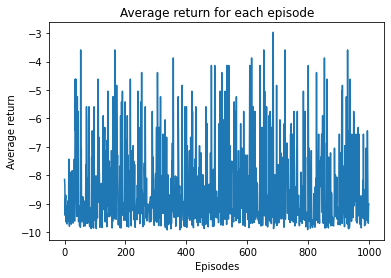

In [ ]:
# define plt
import matplotlib.pyplot as plt
    
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Average return")
plt.title("Average return for each episode")
plt.show()

In [ ]:
def policy_evaluation(self):
        while True:
            delta = 0
            for i in range(self.m):
                for j in range(self.n):
                    for k in range(len(self.actions)):
                        x,y = self.current_pos()
                        action = self.actions[k]
                        next, next_two, con, con2 = self.action_parameter(action)
                        if con == True:
                            if self.grid[next] == self.goal_tile:
                                v = 100
                            elif self.grid[next] == self.ice_tile and con2 == True:
                                if self.grid[next_two] == self.goal_tile:
                                    v = 100
                                elif self.grid[next_two] == self.wall_tile:
                                    v = 0
                                else:
                                    v = 0
                            elif self.grid[next] == self.wall_tile:
                                v = 0
                            elif self.grid[next] == 0:
                                v = 0
                            delta = max(delta, abs(v - self.grid[i,j]))
                            
            if delta < 0.1:
                break

        

    def policy_improvement(self):
        policy_stable = True
        for i in range(self.m):
            for j in range(self.n):
                old_action = self.actions[np.argmax(self.policy[i,j])]
                action_values = []
                for k in range(len(self.actions)):
                    x,y = self.current_pos()
                    action = self.actions[k]
                    next, next_two, con, con2 = self.action_parameter(action)
                    if con == True:
                        if self.grid[next] == self.goal_tile:
                            v = 100
                        elif self.grid[next] == self.ice_tile and con2 == True:
                            if self.grid[next_two] == self.goal_tile:
                                v = 100
                            elif self.grid[next_two] == self.wall_tile:
                                v = 0
                            else:
                                v = 0
                        elif self.grid[next] == self.wall_tile:
                            v = 0
                        elif self.grid[next] == 0:
                            v = 0
                        action_values.append(v)
                new_action = self.actions[np.argmax(action_values)]
                if old_action != new_action:
                    policy_stable = False
                self.policy[i,j] = np.zeros(len(self.actions))
                self.policy[i,j][np.argmax(action_values)] = 1
        return v

    def mc_estimation(self, num_episodes, gamma, policy):
        returns = {}
        for i in range(self.m):
            for j in range(self.n):
                for k in range(len(self.actions)):
                    returns[i,j,k] = []
        for i in range(num_episodes):
            self.reset()
            episode = []
            while self.end == False:
                x,y = self.current_pos()
                action = np.random.choice(self.actions, p = policy[x,y])
                episode.append((x,y,action))
                self.move(action)
            G = 0
            for t in range(len(episode)-1, -1, -1):
                x,y,action = episode[t]
                G = gamma*G + self.get_reward()
                if not (x,y,action) in [(x,y,action) for x,y,action in episode[0:t]]:
                    returns[x,y,action].append(G)
                    self.value[x,y,action] = np.mean(returns[x,y,action])
        return self.value